# Análisis exploratorio EDA: Aprendizaje no supervisado para la identificación de Perfiles Educativos en el ámbito de la Educación Superior en el Ecuador

## Data loading/preprocessing

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Se cargan el archivo de Excel
df_matricula = pd.read_excel("base_matricula_datosabiertos.xlsx", engine='openpyxl')
print(df_matricula.shape)
# Se filtran solo los registros donde "AÑO" de matrícula es igual a 2022
df_matriculas = df_matricula[df_matricula["AÑO"] == 2022]
print(df_matriculas.shape)


(399176, 23)
(140859, 23)


In [13]:
#Se muestra las columnas del conjunto de datos
df_matriculas.columns

Index(['AÑO', 'CODIGO_IES', 'CODIGO_CARRERA', 'TIPO_SEDE', 'PROVINCIA_SEDE',
       'CANTON_SEDE', 'SEXO', 'ETNIA', 'PUEBLOS_NACIONALIDAD', 'DISCAPACIDAD',
       'PAIS_NACIONALIDAD', 'PAIS_RESIDENCIA', 'PROVINCIA_RESIDENCIA',
       'CANTON_RESIDENCIA', 'NOMBRE_IES', 'TIPO_FINANCIAMIENTO',
       'NOMBRE_CARRERA', 'CAMPO_AMPLIO', 'CAMPO_ESPECIFICO', 'CAMPO_DETALLADO',
       'NIVEL_FORMACIÓN', 'MODALIDAD', 'tot'],
      dtype='object')

In [14]:
#Se re etiquetan algunas categorías con nombres demasiado extensos, esto facilita mostrarlas luego en los gráficos.
df_matriculas.loc[:, 'MODALIDAD'] = df_matriculas['MODALIDAD'].replace(['HIBRIDA', 'DUAL'], 'SEMIPRESENCIAL')
df_matriculas.loc[:, 'NIVEL_FORMACIÓN'] = df_matriculas['NIVEL_FORMACIÓN'].replace(['TERCER NIVEL O PREGRADO'], 'PREGRADO')
df_matriculas.loc[:, 'NIVEL_FORMACIÓN'] = df_matriculas['NIVEL_FORMACIÓN'].replace(['CUARTO NIVEL O POSGRADO'], 'POSGRADO')
df_matriculas.loc[:, 'CAMPO_AMPLIO'] = df_matriculas['CAMPO_AMPLIO'].replace(['CIENCIAS SOCIALES, PERIODISMO, INFORMACION Y DERECHO'], 'CIENCIAS SOCIALES Y DERECHO')
df_matriculas.loc[:, 'CAMPO_AMPLIO'] = df_matriculas['CAMPO_AMPLIO'].replace(['AGRICULTURA, SILVICULTURA, PESCA Y VETERINARIA'], 'AGRICULTURA Y VETERINARIA')
df_matriculas.loc[:, 'CAMPO_AMPLIO'] = df_matriculas['CAMPO_AMPLIO'].replace(['CIENCIAS NATURALES, MATEMATICAS Y ESTADISTICA'], 'CIENCIAS NATURALES Y MATEMATICAS')
df_matriculas.loc[:, 'CAMPO_AMPLIO'] = df_matriculas['CAMPO_AMPLIO'].replace(['INGENIERIA, INDUSTRIA Y CONSTRUCCION'], 'INGENIERIA E INDUSTRIA')
df_matriculas.loc[:, 'CAMPO_AMPLIO'] = df_matriculas['CAMPO_AMPLIO'].replace(['TECNOLOGIAS DE LA INFORMACION Y LA COMUNICACION (TIC)'], 'TECNOLOGIAS DE LA INFORMACION')
df_matriculas.loc[:, 'TIPO_FINANCIAMIENTO'] = df_matriculas['TIPO_FINANCIAMIENTO'].replace(['PARTICULAR COFINANCIADA'], 'PARTICULAR')
df_matriculas.loc[:, 'TIPO_FINANCIAMIENTO'] = df_matriculas['TIPO_FINANCIAMIENTO'].replace(['PARTICULAR AUTOFINANCIADA'], 'PARTICULAR')

#Se filtran algunas categorías que no se consideran utiles para el análisis
df_matriculas = df_matriculas[
    (df_matriculas["CAMPO_AMPLIO"] != "NO_REGISTRA") &   #No se considera la categoría "NO_REGISTRA" (10 registros)
    (df_matriculas["PROVINCIA_RESIDENCIA"] != "NO_REGISTRA") &  ##No se considera la categoría "NO_REGISTRA" (810 registros)
    (df_matriculas["PROVINCIA_RESIDENCIA"] != "ZONAS NO DELIMITADAS") &   #No se considera la categoría "ZONAS_NO_DELIMITADAS" (10 registros)
    (df_matriculas["NIVEL_FORMACIÓN"] != "TERCER NIVEL TECNICO-TECNOLOGICO SUPERIOR")  #No se considera la categoría "TERCER NIVEL TECNICO-TECNOLOGICO SUPERIOR" (1431 registros) debido al enfoque del proyecto
]
print("Tamaño después de eliminar registros:", df_matriculas.shape)

Tamaño después de eliminar registros: (138599, 23)


## Exploratory Analysis

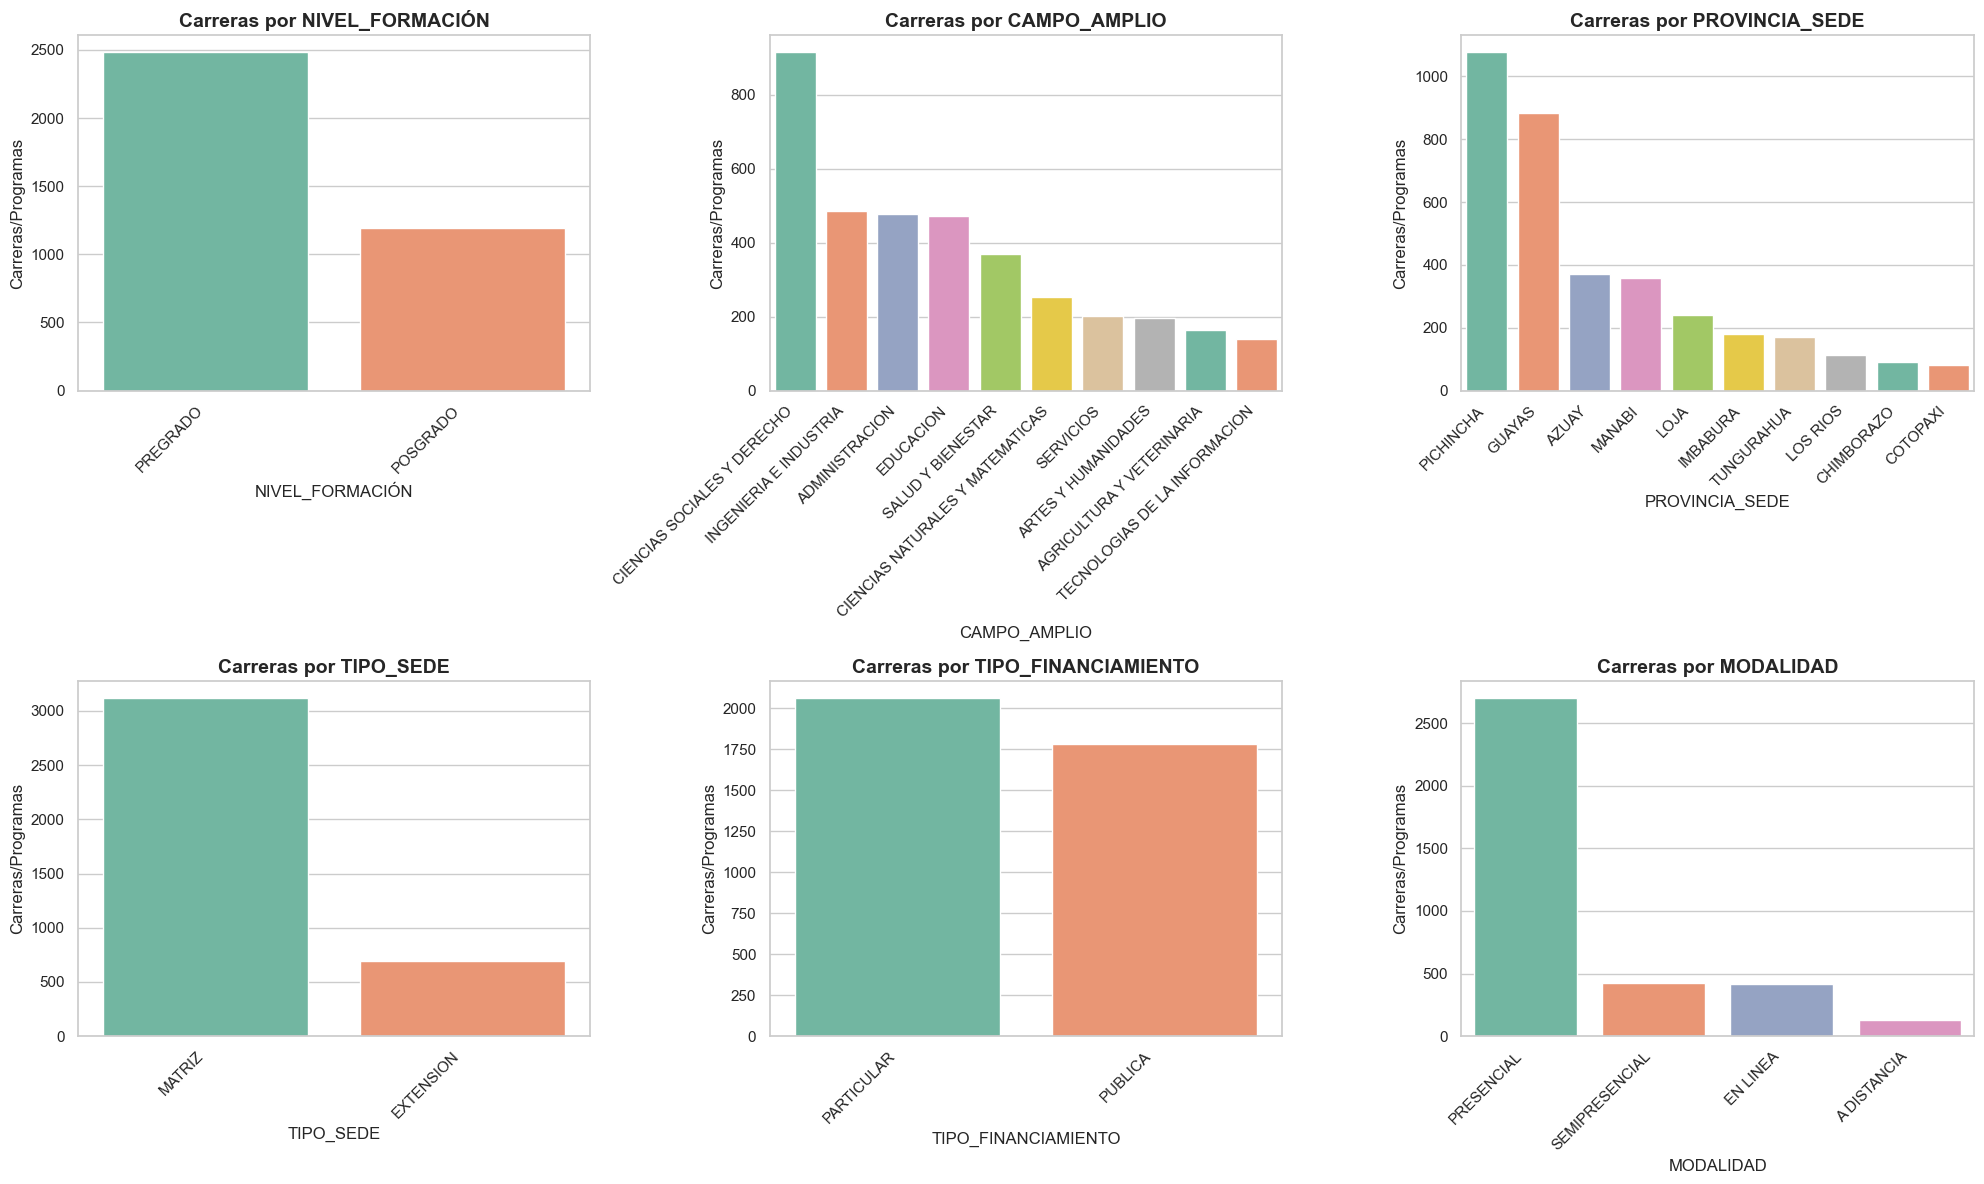

In [15]:
#Distribución de variables categóricas relacionadas a la oferta académica de carreras y programas en el Ecuador, se usa Seaborn

sns.set(style="whitegrid")

# Calculamos el total de carreras distintas
total_carreras = df_matriculas['CODIGO_CARRERA'].nunique()
# Calculamos el total de carreras por 'NIVEL_FORMACIÓN'
carreras_por_nivel = df_matriculas.groupby('NIVEL_FORMACIÓN')['CODIGO_CARRERA'].nunique().sort_values(ascending=False)
# Calculamos el total de carreras por 'NIVEL_FORMACIÓN'
carreras_por_campo = df_matriculas.groupby('CAMPO_AMPLIO')['CODIGO_CARRERA'].nunique().sort_values(ascending=False)
# Calculamos el total de carreras por 'NIVEL_FORMACIÓN'
carreras_por_canton = df_matriculas.groupby('CANTON_SEDE')['CODIGO_CARRERA'].nunique().sort_values(ascending=False)

# Selección de variables relacionadas con la oferta académica para graficar
categorical_columns = ['NIVEL_FORMACIÓN', 'CAMPO_AMPLIO', 'PROVINCIA_SEDE', 'TIPO_SEDE', 'TIPO_FINANCIAMIENTO', 'MODALIDAD']
total_columns = len(categorical_columns)

# Se ajusta el tamaño de la cuadrícula de subplots según el número de variables
rows = (total_columns // 3) + (total_columns % 3 > 0)
plt.figure(figsize=(20, rows * 6))

# Se crea subgráficos para las columnas categóricas
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(rows, 3, i)  # Aquí se ajusta las filas según el número total de variables
    plot_data = df_matriculas.groupby([column])['CODIGO_CARRERA'].nunique().reset_index()
    plot_data.rename(columns={'CODIGO_CARRERA': 'Cantidad de Carreras'}, inplace=True)
    plot_data.sort_values(by='Cantidad de Carreras', ascending=False, inplace=True)

# Para 'PROVINCIA_SEDE', mostramos solo el top 10 para no saturar el gráfico
    if column == 'PROVINCIA_SEDE':
        plot_data = plot_data.head(10)
# Se selecciona la paleta de colores según el número de categorías
    num_categories = len(plot_data)
    if num_categories <= 10:
        palette = sns.color_palette("Set2", num_categories)
    elif num_categories <= 20:
        palette = sns.color_palette("tab20", num_categories)
    else:
        palette = sns.color_palette("husl", num_categories)
# Se realizan los gráficos de barras para cada variable categórica
    sns.barplot(data=plot_data, x=column, y='Cantidad de Carreras', palette=palette)
    plt.title(f"Carreras por {column}", fontsize=14, weight='bold')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Carreras/Programas', fontsize=12)
    plt.xticks(rotation=45, ha="right")
# Se ajusta la disposición de los subgráficos para evitar superposición y se muestra el gráfico
plt.tight_layout()
plt.show()


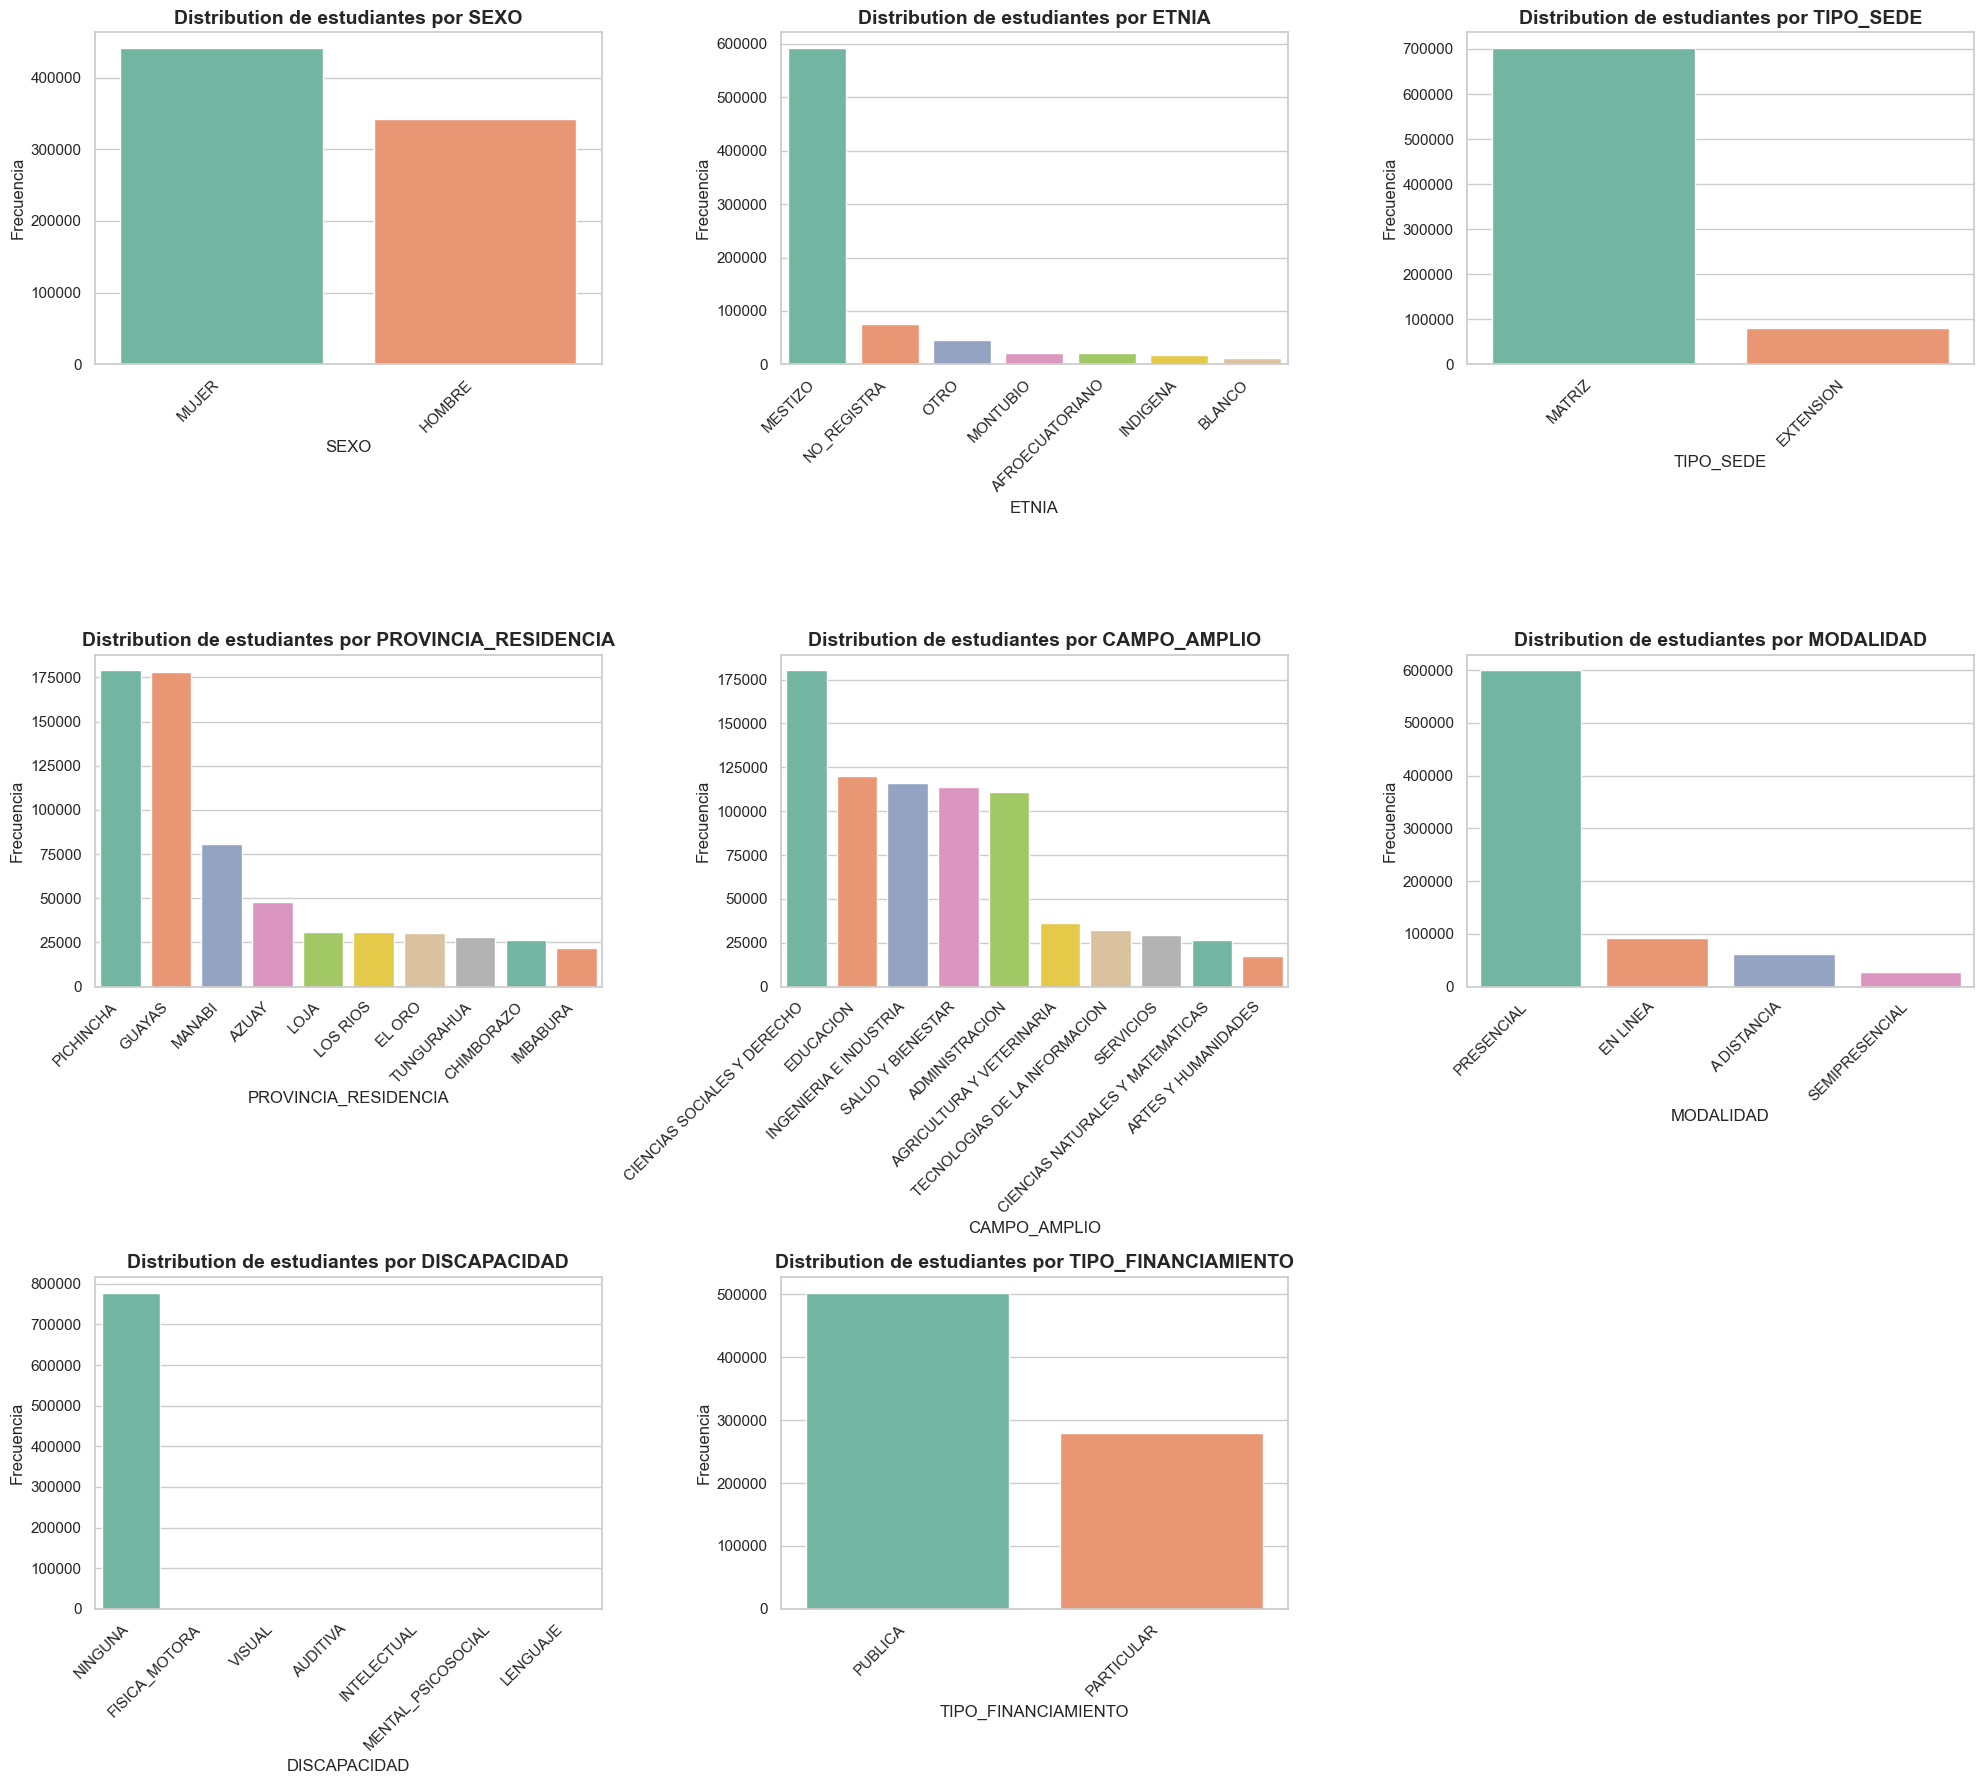

In [16]:
#Distribución de variables categóricas relacionadas a la ditribución de estudiantes matriculados en el Ecuador, se usa Seaborn

sns.set(style="whitegrid")
# Selección de variables relacionadas con las caraterísticas de los estudiantes
categorical_columns = ['SEXO', 'ETNIA', 'TIPO_SEDE', 'PROVINCIA_RESIDENCIA', 'CAMPO_AMPLIO', 'MODALIDAD', 'DISCAPACIDAD', 'TIPO_FINANCIAMIENTO']
total_columns = len(categorical_columns)

# Se ajusta el tamaño de la cuadrícula de subplots según el número de variables
rows = (total_columns // 3) + (total_columns % 3 > 0)
plt.figure(figsize=(20, rows * 6))

# Se crea subgráficos para las columnas categóricas
for i, column in enumerate(categorical_columns, 1):
    plt.subplot(rows, 3, i)  # Aquí se ajusta las filas según el número total de variables
    plot_data = df_matriculas.groupby(column)['tot'].sum().reset_index().sort_values(by='tot', ascending=False)

# Para 'PROVINCIA_RESIDENCIA', mostramos solo el top 10 para no saturar el gráfico
    if column == 'PROVINCIA_RESIDENCIA':
        plot_data = plot_data.head(10)
# Se selecciona la paleta de colores según el número de categorías
    num_categories = len(plot_data)
    if num_categories <= 10:
        palette = sns.color_palette("Set2", num_categories)
    elif num_categories <= 20:
        palette = sns.color_palette("tab20", num_categories)
    else:
        palette = sns.color_palette("husl", num_categories)
# Se realizan los gráficos de barras para cada variable categórica
    sns.barplot(data=plot_data, x=column, y='tot', palette=palette)
    plt.title(f"Distribution de estudiantes por {column}", fontsize=14, weight='bold')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.xticks(rotation=45, ha="right")
# Se ajusta la disposición de los subgráficos para evitar superposición y se muestra el gráfico
plt.tight_layout()
plt.show()


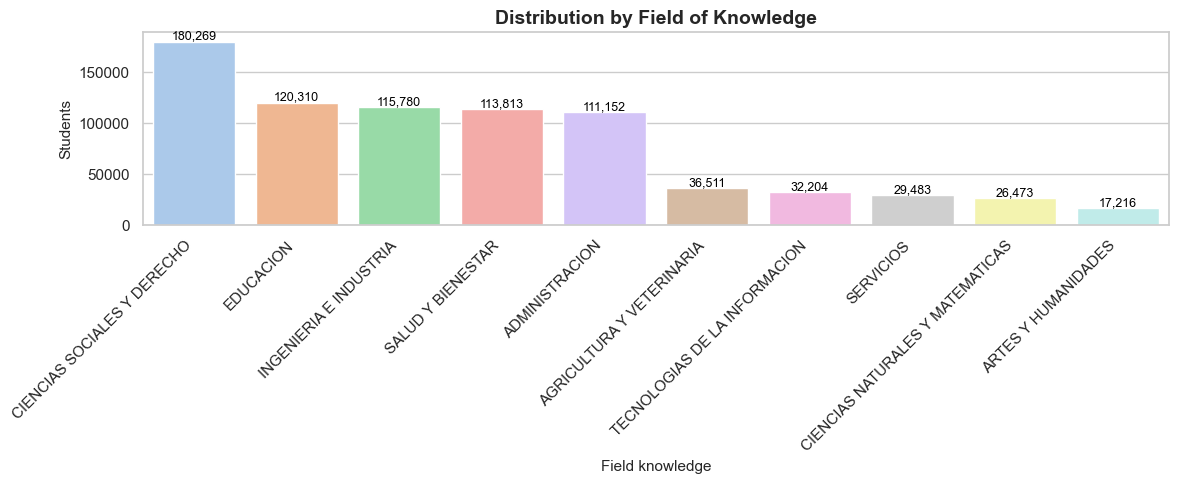

In [17]:
#Distribución de estudiantes por campo de conocimiento en el que se han matriculado
# Se establece el estilo y una paleta de colores pastel
sns.set(style="whitegrid")
palette = sns.color_palette("pastel")  # Paleta en tonos pastel
# Se agrupa y se ordena los datos por frecuencia en 'CAMPO_AMPLIO'
plot_data = df_matriculas.groupby('CAMPO_AMPLIO')['tot'].sum().reset_index().sort_values(by='tot', ascending=False)
# Se crea el gráfico de barras para 'CAMPO_AMPLIO' y se agregan etiquetas
plt.figure(figsize=(12, 5))
barplot = sns.barplot(data=plot_data, x='CAMPO_AMPLIO', y='tot', palette=palette)
plt.title("Distribution by Field of Knowledge", fontsize=14, weight='bold')
plt.xlabel("Field knowledge", fontsize=11)
plt.ylabel("Students", fontsize=11)
plt.xticks(rotation=45, ha="right")
for i, value in enumerate(plot_data['tot']):
    barplot.text(i, value + 2000, f"{int(value):,}", color='black', ha="center", fontsize=9)

# Se ajusta el diseño para evitar etiquetas recortadas, se guarda el gráfico y se lo muestra
plt.tight_layout()
plt.savefig("distribucion_estudiantes_campo_amplio.png", format="png", dpi=300)
plt.show()


In [18]:
#Sunburst de la oferta académica del Ecuador
import pandas as pd
import plotly.express as px
import plotly.colors as pc

# Se define la paleta de colores personalizada
color_sequence = [ 'rgba(255, 215, 0, 0.5)', 'rgba(128, 128, 128, 0.7)', 'white']
# Se agrupa los datos para crear el gráfico sunburst
sunburst_data = df_matriculas.groupby(['TIPO_FINANCIAMIENTO', 'NIVEL_FORMACIÓN', 'MODALIDAD', 'CAMPO_AMPLIO'])['CODIGO_CARRERA'].nunique().reset_index()
sunburst_data.rename(columns={'CODIGO_CARRERA': 'Cantidad de Carreras'}, inplace=True)
# Se identifica el top 3 de 'CAMPO_AMPLIO' por cantidad de carreras/programas y se agrupa las demas categorías en la categoría 'Otros' 
# Esto para evitar sobrecargar el gráfico y solo mostrar los campos principales
top_3_campo_amplio = sunburst_data.groupby('CAMPO_AMPLIO')['Cantidad de Carreras'].sum().nlargest(3).index
sunburst_data['CAMPO_AMPLIO'] = sunburst_data['CAMPO_AMPLIO'].apply(lambda x: x if x in top_3_campo_amplio else 'Otros')
sunburst_data = sunburst_data.groupby(['TIPO_FINANCIAMIENTO', 'NIVEL_FORMACIÓN', 'MODALIDAD', 'CAMPO_AMPLIO'])['Cantidad de Carreras'].sum().reset_index()
# Se añade una columna ficticia para representar el total en el centro
sunburst_data['Total'] = 'OFERTA'
# Se crea el gráfico sunburst con el mapa de colores personalizado
fig = px.sunburst(
    sunburst_data,
    path=['Total', 'TIPO_FINANCIAMIENTO', 'NIVEL_FORMACIÓN', 'MODALIDAD', 'CAMPO_AMPLIO'],  # Se agrega la columna ficticia como raíz del gráfico
    values='Cantidad de Carreras',
    color='TIPO_FINANCIAMIENTO',  # Colorea por la categoría TIPO_FINANCIAMIENTO
    color_discrete_map=None,  # No se usa el mapa de colores aquí
    color_discrete_sequence=color_sequence,  # Se usa la secuencia de colores personalizada
    
)
# Se actualizan los detalles del gráfico
fig.update_traces(
    textinfo='label+percent entry',
    hoverinfo='label+percent entry',
    insidetextorientation='radial',
    textfont_size=12
)
# Se agrega una anotación en el centro para mostrar solo el número total de carreras
total_carreras_sunburst = total_carreras
fig.update_layout(
    title_x=0.5,  # Centra el título del gráfico
    annotations=[{
        'text': f'{total_carreras_sunburst}',  # Muestra solo el número en el centro
        'x': 0.5,
        'y': 0.48,
        'font_size': 24,
        'showarrow': False,
        'font_color': 'black'
    }],
    paper_bgcolor='white',
    font=dict(size=20),
    margin=dict(t=50, l=50, r=50, b=50),
    width=1000,
    height=1000
)
#Se guarda y se muestra el gráfico
fig.write_image("sunburst_oferta_carreras.png")
fig.show()


In [19]:
#Sunburst de la distribución de estudiantes 
import pandas as pd
import plotly.express as px

# Se define una paleta de colores personalizada
color_sequence = [ 'rgba(255, 215, 0, 0.5)', 'rgba(128, 128, 128, 0.8)', 'white']
# Se agrupa los datos para crear el gráfico sunburst usando la columna "tot" para el total de estudiantes
sunburst_data = df_matriculas.groupby(['TIPO_FINANCIAMIENTO', 'NIVEL_FORMACIÓN', 'MODALIDAD', 'CAMPO_AMPLIO'])['tot'].sum().reset_index()
sunburst_data.rename(columns={'tot': 'Total Estudiantes'}, inplace=True)
# Se añade una columna ficticia para representar el total en el centro
sunburst_data['Total'] = 'ESTUDIANTES'
# Se crea el gráfico sunburst con el mapa de colores personalizado
fig = px.sunburst(
    sunburst_data,
    path=['Total', 'TIPO_FINANCIAMIENTO', 'NIVEL_FORMACIÓN', 'MODALIDAD', 'CAMPO_AMPLIO'],  # Se agrega 'Total' como raíz del gráfico
    values='Total Estudiantes',
    color='TIPO_FINANCIAMIENTO',  # Colorea por la categoría TIPO_FINANCIAMIENTO
    color_discrete_map=None,  # No se usa el mapa de colores aquí
    color_discrete_sequence=color_sequence,  # Se usa la secuencia de colores personalizada
)
# Se actualiza los detalles del gráfico
fig.update_traces(
    textinfo='label+percent entry',
    hoverinfo='label+percent entry',
    insidetextorientation='radial',
    textfont_size=12
)
# Se agrupa una anotación en el centro para mostrar solo el número total de estudiantes
total_estudiantes = sunburst_data['Total Estudiantes'].sum()
fig.update_layout(
    title_x= 0.5,
    annotations=[{
        'text': f'{total_estudiantes}',  # Muestra solo el número en el centro
        'x': 0.5,
        'y': 0.48,
        'font_size': 24,
        'showarrow': False,
        'font_color': 'black',
        'xanchor': 'center',
        'yanchor': 'middle'
    }],
    paper_bgcolor='white',
    font=dict(size=20),
    margin=dict(t=50, l=50, r=50, b=50),
    width=1000,
    height=1000
)
# Se guarda y se muestra el gráfico
fig.write_image("sunburst_estudiantes.png")
fig.show()


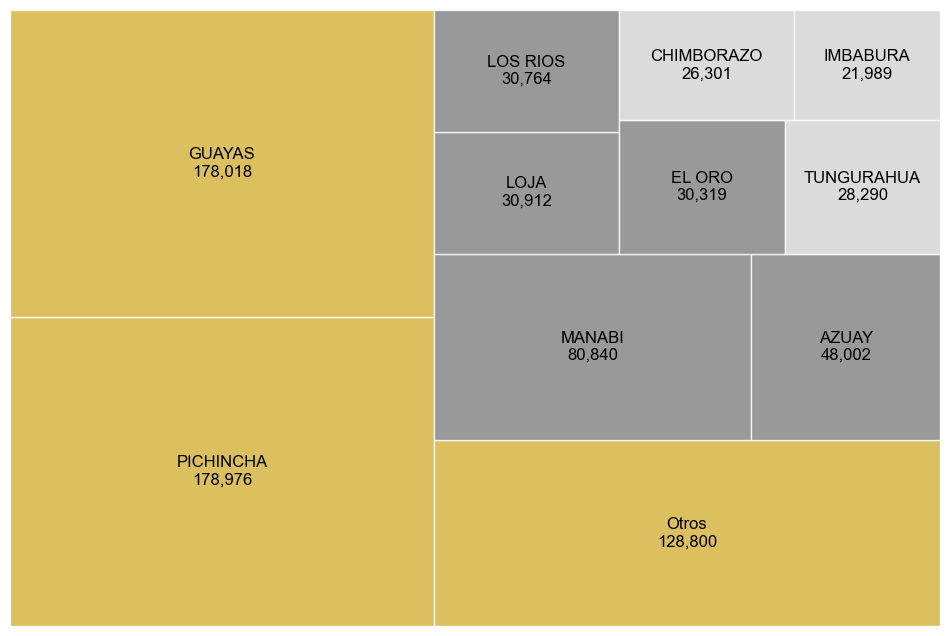

In [20]:
# Creación de treemap con la oferta académica por provincia
import pandas as pd
import matplotlib.pyplot as plt
import squarify  # Biblioteca para treemaps
# Se agrupa los datos por provincia y y se genera el top 10 de acuerdo con la cantidad
provincia_totales = df_matriculas.groupby('PROVINCIA_RESIDENCIA')['tot'].sum().reset_index()
top_10_provincias = provincia_totales.nlargest(10, 'tot')
# Se calcula la suma de las demás provincias y creamos la fila "Otros"
otros = pd.DataFrame({
    'PROVINCIA_RESIDENCIA': ['Otros'],
    'tot': [provincia_totales['tot'].sum() - top_10_provincias['tot'].sum()]
})
# Se concatena el top 10 con la categoría "Otros" y ordenamos de mayor a menor
treemap_data = pd.concat([top_10_provincias, otros], ignore_index=True).sort_values(by='tot', ascending=False)
# Se define la paleta de colores en formato hexadecimal para cada rango
colors = []
for value in treemap_data['tot']:
    if value > 100000:
        colors.append('#D4AF37')  # Dorado pastel para > 100000
    elif 30000 <= value <= 100000:
        colors.append('#808080')  # Gris oscuro pastel para 100000 >= valor >= 30000
    else:
        colors.append('#D3D3D3')  # Gris claro pastel para < 30000
# Se crea el treemap
plt.figure(figsize=(12, 8))
squarify.plot(
    sizes=treemap_data['tot'],
    label=treemap_data['PROVINCIA_RESIDENCIA'] + "\n" + treemap_data['tot'].apply(lambda x: f'{x:,}'),
    color=colors,
    alpha=0.8,
    text_kwargs={'fontsize': 12, 'color': 'black'}
)
plt.axis('off')  # Ocultar los ejes
# Se guarda y se muestra el gráfico
plt.savefig("top_10_estudiantes_provincia_treemap.png", format="png", dpi=300)
plt.show()


In [ ]:
#Grafo de la cantidad de estudiantes por provincia y por cada campo de conocimiento
#Es útil para entender la distribución de los estudiantes en territorio y poderlo relacionar con las necesidades de cada uno de estos territorios
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import networkx as nx
# Se agrupa el dataset para evitar duplicados y sumar 'tot' por combinación de provincia y campo amplio
df_grouped = df_matriculas.groupby(['PROVINCIA_RESIDENCIA', 'CAMPO_AMPLIO'])['tot'].sum().reset_index()
# Se extrae lista única de provincias y campos amplios del dataset agrupado
provincias = df_grouped["PROVINCIA_RESIDENCIA"].unique().tolist()
secondary_nodes = df_grouped["CAMPO_AMPLIO"].unique().tolist()
# Se genera 'tot_values_by_province' que mapea cada provincia con una lista de valores 'tot' por cada campo amplio
tot_values_by_province = {
    provincia: df_grouped[df_grouped['PROVINCIA_RESIDENCIA'] == provincia]
        .set_index('CAMPO_AMPLIO')['tot']
        .reindex(secondary_nodes, fill_value=0)
        .tolist()
    for provincia in provincias
}
# Se crea el widget de selección de provincia esto permitirá interactuar con el grafo
provincia_selector = widgets.Dropdown(
    options=provincias,
    description='Provincia:',
    value=provincias[13]  # Valor inicial
)
# Se define una función para dividir el texto en dos líneas si es muy largo y añadir el valor de 'tot', esto por un tema de visuallzaición
def split_text_with_tot(text, tot_value, max_length=15):
    words = text.split()
    half = len(words) // 2
    if len(text) > max_length and len(words) > 1:
        label = "\n".join([" ".join(words[:half]), " ".join(words[half:])])
    else:
        label = text
    # Se añade el valor de 'tot' en una nueva línea
    return f"{label}\nEstudiantes: {tot_value}"
# Se define una función para actualizar el grafo según la provincia seleccionada
def update_graph(provincia):
    # Se obtiene los valores de 'tot' para la provincia seleccionada
    tot_values = tot_values_by_province[provincia]
    # Se crea el grafo
    G = nx.Graph()
    G.add_node(provincia)
    node_sizes = [5000] + [value * 1 for value in tot_values]  # Se define un tamaño mayor para el nodo raíz, y la proporción en relación a los nodos secundarios
    for i, node in enumerate(secondary_nodes):
        G.add_node(node)
        G.add_edge(provincia, node)
    # Se definen los colores para el nodo raíz y nodos secundarios
    node_colors = ["#1A237E"] + ["#D3D3D3"] * len(secondary_nodes)  # Azul oscuro para el nodo raíz y gris claro para secundarios
    # Se crean etiquetas de nodos con texto dividido y con valor de 'tot'
    labels = {node: split_text_with_tot(node, tot_values[i]) for i, node in enumerate(secondary_nodes)}
    labels[provincia] = provincia  # Etiqueta sin cambio para el nodo raíz
    # Se dibuja el grafo sin etiquetas en nx.draw
    plt.figure(figsize=(14, 12))
    pos = nx.shell_layout(G, [list(G.neighbors(provincia)), [provincia]])  # Usar shell layout para disposición de estrella
    nx.draw(G, pos, node_size=node_sizes, font_size=8, node_color=node_colors, edge_color="gray")
    # Se añade las etiquetas de los nodos manualmente
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=7, font_color="darkblue")
    nx.draw_networkx_labels(G, pos, labels={provincia: provincia}, font_size=12, font_weight="bold", font_color="white")

    plt.title(f"Grafo de distribucion de estudiantes en {provincia}", fontsize=40)

# Se conecta la función de actualización con el widget para hacerlo interactivo
interact = widgets.interactive(update_graph, provincia=provincia_selector)
display(interact)


interactive(children=(Dropdown(description='Provincia:', index=13, options=('AZUAY', 'BOLIVAR', 'CARCHI', 'CAÑ…